In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import torch

In [2]:
def fgsm_attack(image, epsilon, gradient):
    adversarial_image = image + epsilon * gradient
    adversarial_image = np.clip(adversarial_image, 0, 255)
    return adversarial_image.astype(np.uint8)

In [3]:
def add_noise(image_np, noise_level=10.0):
    noise = np.random.normal(scale=noise_level, size=image_np.shape)
    noisy_image = image_np + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

In [4]:
zip_path = '/content/Detect_AI_Art.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

real_folder = '/content/REAL/'
fake_folder = '/content/FAKE/'

os.makedirs('/content/REAL_resized', exist_ok=True)
os.makedirs('/content/FAKE_resized', exist_ok=True)

for filename in os.listdir(real_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(real_folder, filename)
        output_path = os.path.join('/content/REAL_resized', filename)
        with Image.open(image_path) as img:
            #img_resized = img.resize((256, 256))
            img_resized = img
            img_resized.save(output_path)

for filename in os.listdir(fake_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(fake_folder, filename)
        output_path = os.path.join('/content/FAKE_resized', filename)
        with Image.open(image_path) as img:
            #img_resized = img.resize((256, 256))
            img_resized = img
            img_resized.save(output_path)


In [5]:
import random
real_filenames = os.listdir('/content/REAL_resized')
random_real_files = random.sample(real_filenames, min(200, len(real_filenames)))

fake_filenames = os.listdir('/content/FAKE_resized')
random_fake_files = random.sample(fake_filenames, min(200, len(fake_filenames)))

In [6]:
import time

X_original = []
y_original = []

for filename in random_real_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/REAL_resized', filename))
        X_original.append(np.array(img).flatten())
        y_original.append(1)

for filename in random_fake_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/FAKE_resized', filename))
        X_original.append(np.array(img).flatten())
        y_original.append(0)

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

start_time = time.time()
model_original = LogisticRegression(max_iter=1000)
model_original.fit(X_original_train, y_original_train)
end_time = time.time()

y_original_pred = model_original.predict(X_original_test)

accuracy_original = accuracy_score(y_original_test, y_original_pred)
conf_matrix_original = confusion_matrix(y_original_test, y_original_pred)

runtime = end_time - start_time
print("Runtime of model training:", runtime, "seconds")

Runtime of model training: 58.12583041191101 seconds


Log Regression With Blurry Test

In [7]:
X_resized_with_noise = []
y_resized_with_noise = []

for filename in random_real_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/REAL_resized', filename))
        X_resized_with_noise.append(np.array(img).flatten())
        y_resized_with_noise.append(1)

for filename in random_fake_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/FAKE_resized', filename))
        X_resized_with_noise.append(np.array(img).flatten())
        y_resized_with_noise.append(0)

X_resized_with_noise = np.array(X_resized_with_noise)
y_resized_with_noise = np.array(y_resized_with_noise)

X_with_noise_train, X_with_noise_test, y_with_noise_train, y_with_noise_test = train_test_split(X_resized_with_noise, y_resized_with_noise, test_size=0.2, random_state=42)

X_with_noise_test_noisy = []
for img_array in X_with_noise_test:
    noisy_img_array = add_noise(img_array)
    X_with_noise_test_noisy.append(noisy_img_array)

X_with_noise_test_noisy = np.array(X_with_noise_test_noisy)

In [8]:
model_with_noise = LogisticRegression(max_iter=1000)
model_with_noise.fit(X_with_noise_train, y_with_noise_train)

y_with_noise_pred = model_with_noise.predict(X_with_noise_test_noisy)

accuracy_with_noise = accuracy_score(y_with_noise_test, y_with_noise_pred)
conf_matrix_with_noise = confusion_matrix(y_with_noise_test, y_with_noise_pred)


Adding Noise (ignore FGSM, just adding random noise now)

In [9]:
X_resized_with_noise = []
y_resized_with_noise = []

for filename in random_real_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/REAL_resized', filename))
        X_resized_with_noise.append(np.array(img).flatten())
        y_resized_with_noise.append(1)

for filename in random_fake_files:
    if filename.endswith('.jpg'):
        img = Image.open(os.path.join('/content/FAKE_resized', filename))
        X_resized_with_noise.append(np.array(img).flatten())
        y_resized_with_noise.append(0)

X_resized_with_noise = np.array(X_resized_with_noise)
y_resized_with_noise = np.array(y_resized_with_noise)

X_with_noise_train, X_with_noise_test, y_with_noise_train, y_with_noise_test = train_test_split(X_resized_with_noise, y_resized_with_noise, test_size=0.2, random_state=42)


X_with_noise_test_adversarial = []

epsilon = 1.0

for img_array in X_with_noise_test:
    gradient = np.random.randn(*img_array.shape)
    adversarial_img_array = fgsm_attack(img_array, epsilon, gradient)
    X_with_noise_test_adversarial.append(adversarial_img_array)

X_with_noise_test_adversarial = np.array(X_with_noise_test_adversarial)

In [10]:
model_with_adversarial = LogisticRegression(max_iter=1000)
model_with_adversarial.fit(X_with_noise_train, y_with_noise_train)

y_with_noise_adversarial = model_with_adversarial.predict(X_with_noise_test_adversarial)

In [11]:
accuracy_with_adversarial = accuracy_score(y_with_noise_test, y_with_noise_adversarial)
conf_matrix_with_adversarial = confusion_matrix(y_with_noise_test, y_with_noise_adversarial)

In [17]:
import seaborn as sns
def print_confusion_matrix(title, confusion_matrix):
    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Print Results

Accuracy for Original Images: 0.9


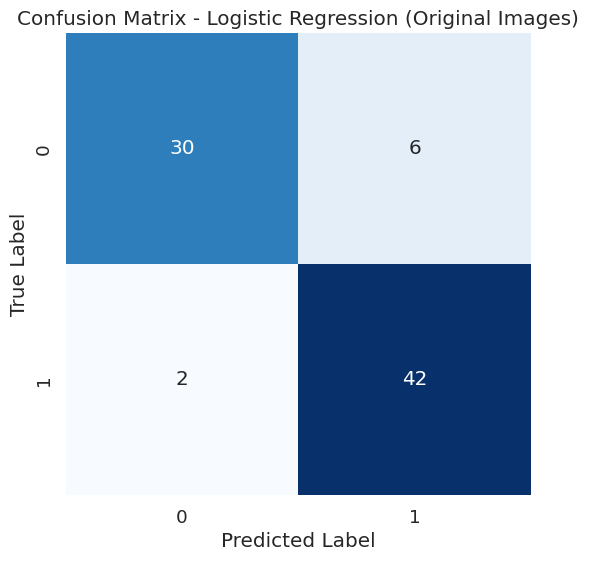


Accuracy for Resized Images with Added Noise: 0.8875


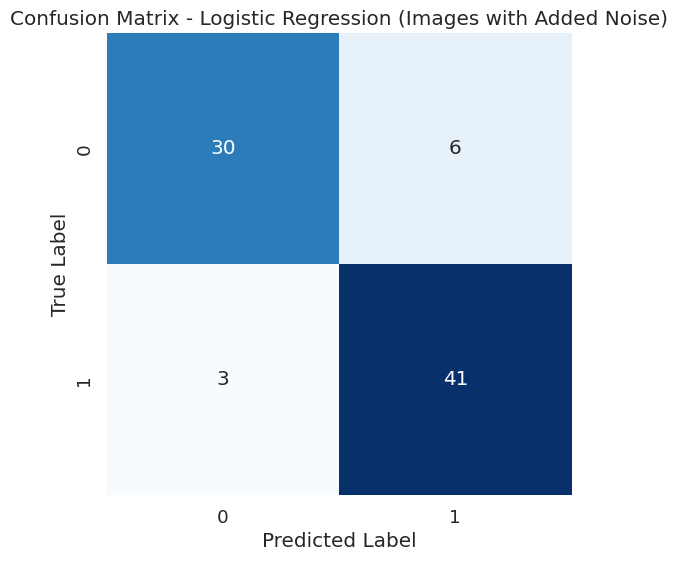


Accuracy for Resized Images with Random Noise: 0.8875


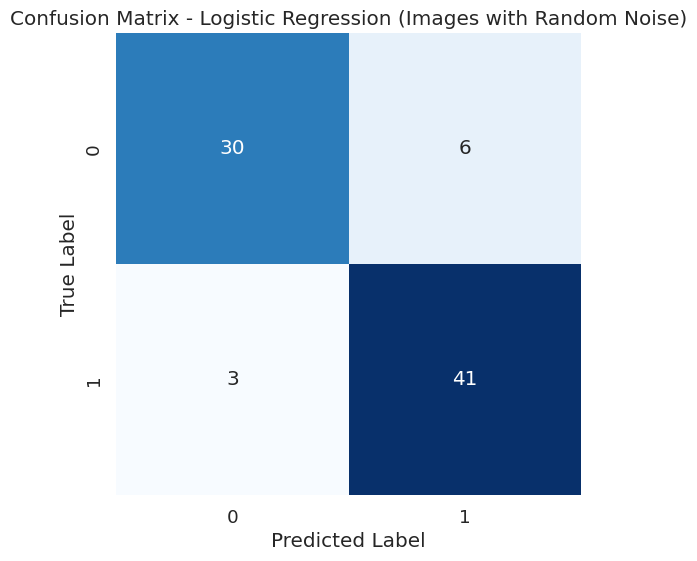

In [18]:
print("Accuracy for Original Images:", accuracy_original)
print_confusion_matrix("Confusion Matrix - Logistic Regression (Original Images)", conf_matrix_original)
print()
print("Accuracy for Resized Images with Added Noise:", accuracy_with_noise)
print_confusion_matrix("Confusion Matrix - Logistic Regression (Images with Added Noise)", conf_matrix_with_noise)
print()
print("Accuracy for Resized Images with Random Noise:", accuracy_with_adversarial)
print_confusion_matrix("Confusion Matrix - Logistic Regression (Images with Random Noise)", conf_matrix_with_adversarial)

Plot Blurry vs. Non-blurred Images

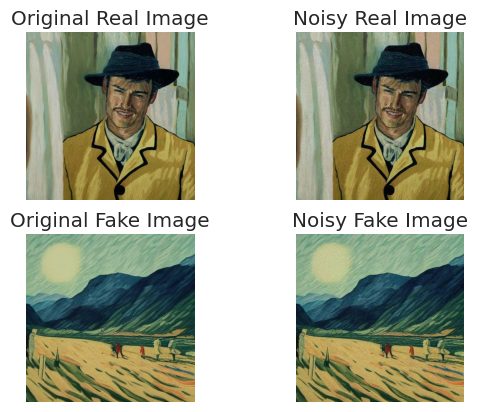

In [21]:
import matplotlib.pyplot as plt

real_index = np.where(y_with_noise_test == 1)[0][0]
fake_index = np.where(y_with_noise_test == 0)[0][0]

plt.subplot(2, 2, 1)
plt.imshow(X_with_noise_test[real_index].reshape((512, 512, 3)))
plt.title("Original Real Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X_with_noise_test_noisy[real_index].reshape((512, 512, 3)))
plt.title("Noisy Real Image")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_with_noise_test[fake_index].reshape((512, 512, 3)))
plt.title("Original Fake Image")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X_with_noise_test_noisy[fake_index].reshape((512, 512, 3)))
plt.title("Noisy Fake Image")
plt.axis('off')

plt.show()

FGSM Pictures

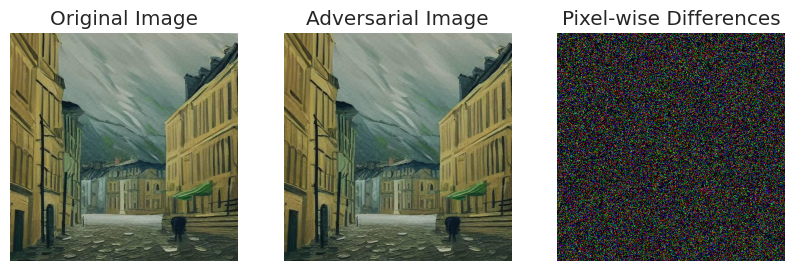

In [25]:
import matplotlib.pyplot as plt

img_array_reshaped = img_array.reshape((512, 512, 3))

pixel_diff = np.abs(img_array_reshaped - adversarial_img_array.reshape(512,512,3))

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_array_reshaped)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adversarial_img_array.reshape(512,512,3))
plt.title("Adversarial Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pixel_diff, cmap='gray')
plt.title("Pixel-wise Differences")
plt.axis('off')

plt.show()

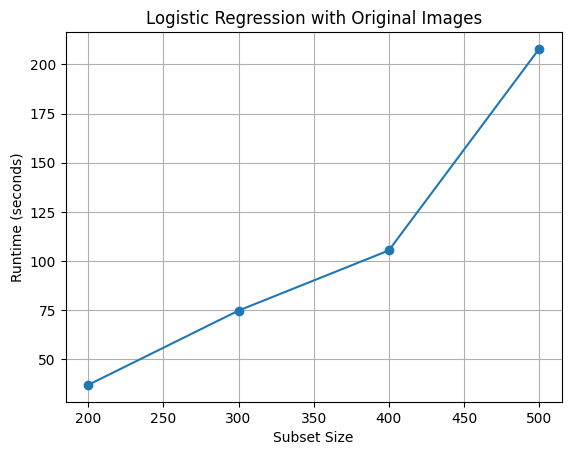

In [ ]:
# Plot the runtimes
subset_sizes = [200, 300, 400, 500]
runtimes = [36.983283042907715,74.78550958633423 ,105.38338446617126 , 207.86998319625854]
plt.plot(subset_sizes, runtimes, marker='o')
plt.title('Logistic Regression with Original Images')
plt.xlabel('Subset Size')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()